# Time Conversion and Comparison

The conversion constant from code time to sec is:
$u_T = M_{Sun} G/c^3 = 4.925490947 \times 10^{-6} \  s$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image #for importing the photos for comparison
import os
import glob

### Import Comparison Run for Each Code

We choose a run from each dataset which has similar total mass and mass ratio as well as similar tidal deformability as given below.
- SXS: EOS = hMlR, $M = 2.72 M_o$, $\Lambda = 588$, $M_c = 1.184$ (SXS_hMlR_136_136)
- Whisky: EOS = ALF2, $M = 2.8 M_o$, $\Lambda = 591.07$, $M_c = 1.21$ (Whisky_ALF2_1400_1400)
- THC, EOS = BLh, $M = 2.66 M_o$, $\Lambda = 593.93$, $M_c = 1.16$ (THC0100)
- SACRA: EOS = H, $M = 2.70 M_o$, $\Lambda = 607$, $M_c = 1.175$ (SACRA_H_135_135)
- BAM: EOS = MPA1, $M = 2.69$, $\Lambda = 608.58$, , $M_c = 1.175$ (BAM0058)

  Notes:
  - to transform time from code units to sec, multiply with $uT = 4.925490947\times10^{−6}$
  - SACRA and Whisky Strain need to be rescaled with total mass
  - SXS time must be multiplied with total mass

In [2]:
df_SXS = pd.read_csv('SpEC/SXS_hMlR_136_136_h.txt', header=None, names=['time', 'Real_h', 'Imag_h'], sep=r'\s+')
df_Whisky = pd.read_csv('Whisky/Whisky_ALF2_1400_1400_h.txt', header=None, names=['time', 'Real_h', 'Imag_h'], sep=r'\s+')
df_THC = pd.read_csv('THC/THC0100_BLh_1333_1333_h.txt', header=None, names=['u/M', 'Real_h', 'Imag_h', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 'time'], sep=r'\s+')
df_SACRA = pd.read_csv('SACRA/SACRA_H_135_135_h.txt', header=None, names=['time', 'Real_h', 'Imag_h'], sep=r'\s+')
df_BAM = pd.read_csv('BAM/BAM0058_MPA1_1350_1350_h_r1000.txt', header=None, names=['u/M', 'Real_h', 'Imag_h', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 'time'], sep=r'\s+')

Text(0.5, 1.0, 'SXS Strain')

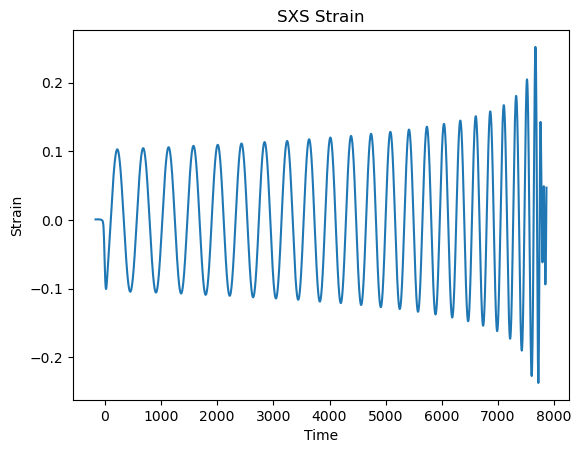

In [3]:
MSXS = 2.72
#Plot SXS Data to test
plt.plot(df_SXS['time']*MSXS, df_SXS['Real_h'])
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('SXS Strain')

Text(0.5, 1.0, 'Whisky Strain')

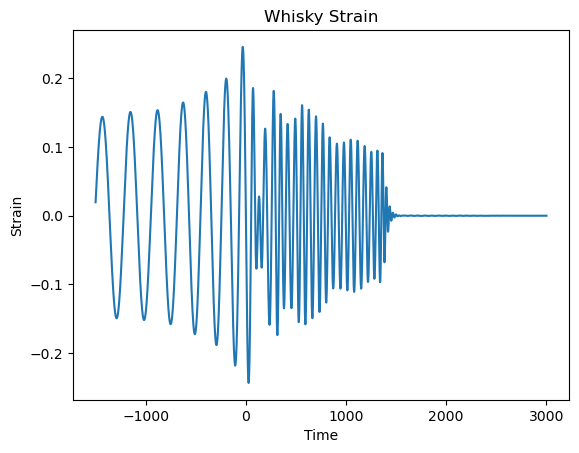

In [4]:
#Plot Whisky Data to test
MWhisky = 2.8
plt.plot(df_Whisky['time'], df_Whisky['Real_h']/MWhisky)
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('Whisky Strain')

Text(0.5, 1.0, 'THC Strain')

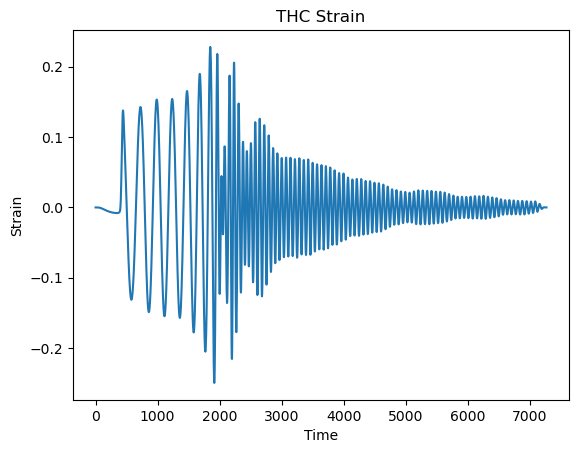

In [5]:
#Plot THC Data to test
MTHC = 2.66
plt.plot(df_THC['time'], df_THC['Real_h'])
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('THC Strain')

Text(0.5, 1.0, 'SACRA Strain')

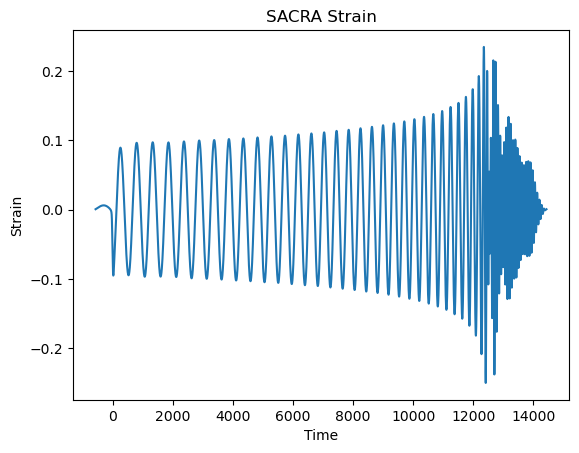

In [6]:
#Plot SACRA Data to test
MSACRA = 2.7
plt.plot(df_SACRA['time'], df_SACRA['Real_h']/MSACRA)
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('SACRA Strain')

Text(0.5, 1.0, 'BAM Strain')

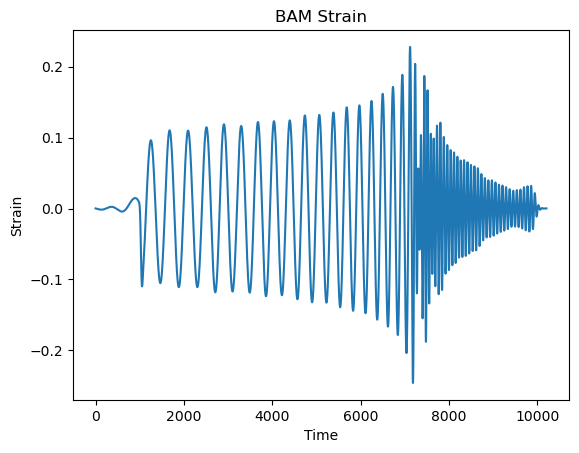

In [7]:
#Plot BAM Data to test
MBAM = 2.69
plt.plot(df_BAM['time'], df_BAM['Real_h'])
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('BAM Strain')

In [8]:
def process_waveform_p(df, output_path, scale_h, scale_time):
    # 1. Rescale 'Real_h' and 'Imag_h'
    df['Real_h'] *= scale_h
    df['Imag_h'] *= scale_h

    # 2. Rescale 'time'
    df['time'] *= scale_time

    # 3. Calculate Amplitude Amp = sqrt(Real_h^2 + Imag_h^2)
    df['Amp'] = np.sqrt(df['Real_h']**2 + df['Imag_h']**2)

    # 4. Find time of max amplitude and rescale time
    time_max_amp = df['time'].loc[df['Amp'].idxmax()]  # Time at max amplitude
    df['time_sec'] = df['time'] - time_max_amp

    # 5. Calculate and unwrap phase = -arctan(Imag_h / Real_h)
    df['phase'] = np.arctan2(df['Imag_h'], df['Real_h'])
    df['phase_unwrapped'] = np.unwrap(df['phase'])

    # 6. Calculate frequency = gradient(phase)
    df['freq'] = np.gradient(df['phase_unwrapped'], df['time_sec'])

    # 7. Recalculate phase by integrating frequency
    df['recalc_phase'] = np.cumsum(df['freq'] * np.gradient(df['time_sec']))
    phase_max_amp = df['recalc_phase'].loc[df['Amp'].idxmax()]  # Phase at max amplitude
    df['recalc_phase'] -= phase_max_amp

    # Save the processed data to the specified output file
    df.to_csv(output_path, index=False)

    print(f"Processed data saved to {output_path}")

In [9]:
def process_waveform_m(df, output_path, scale_h, scale_time):
    # 1. Rescale 'Real_h' and 'Imag_h'
    df['Real_h'] *= scale_h
    df['Imag_h'] *= scale_h

    # 2. Rescale 'time'
    df['time'] *= scale_time

    # 3. Calculate Amplitude Amp = sqrt(Real_h^2 + Imag_h^2)
    df['Amp'] = np.sqrt(df['Real_h']**2 + df['Imag_h']**2)

    # 4. Find time of max amplitude and rescale time
    time_max_amp = df['time'].loc[df['Amp'].idxmax()]  # Time at max amplitude
    df['time_sec'] = df['time'] - time_max_amp

    # 5. Calculate and unwrap phase = -arctan(Imag_h / Real_h)
    df['phase'] = -np.arctan2(df['Imag_h'], df['Real_h'])
    df['phase_unwrapped'] = np.unwrap(df['phase'])

    # 6. Calculate frequency = gradient(phase)
    df['freq'] = np.gradient(df['phase_unwrapped'], df['time_sec'])

    # 7. Recalculate phase by integrating frequency
    df['recalc_phase'] = np.cumsum(df['freq'] * np.gradient(df['time_sec']))
    #initial_phase = df['recalc_phase'].iloc[0]
    phase_max_amp = df['recalc_phase'].loc[df['Amp'].idxmax()]  # Time at max amplitude
    df['recalc_phase'] -= phase_max_amp
    
    # Save the processed data to the specified output file
    df.to_csv(output_path, index=False)

    print(f"Processed data saved to {output_path}")

In [10]:
uT = 4.925490947e-6
# Call the function to process the data and save it to 'processed_data.csv'
scale_time = MSXS*uT
scale_h = 1.0
#Plot SXS Data to test
process_waveform_p(df_SXS, 'SXS_hMlR_data.csv', scale_h, scale_time)

Processed data saved to SXS_hMlR_data.csv


Text(0, 0.5, 'Data')

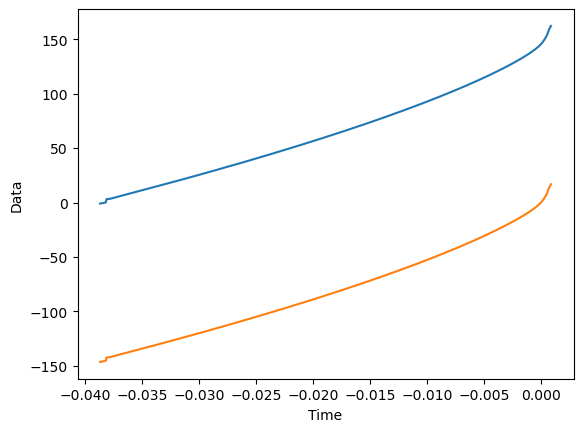

In [11]:
df_SXS_data = pd.read_csv('SXS_hMlR_data.csv')
#Plot SXS Data to test
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['Real_h'])
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['Amp'])
plt.plot(df_SXS_data['time_sec'], df_SXS_data['phase_unwrapped'])
plt.plot(df_SXS_data['time_sec'], df_SXS_data['recalc_phase'])
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['recalc_phase'])
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['freq'])
plt.xlabel('Time')
plt.ylabel('Data')
#plt.title('SXS Strain')

In [12]:
# Call the function to process the data and save it to 'processed_data.csv'
scale_time = uT
scale_h = 1/MWhisky
#Plot Whisky Data to test
process_waveform_p(df_Whisky, 'Whisky_ALF2_data.csv', scale_h, scale_time)

Processed data saved to Whisky_ALF2_data.csv


Text(0.5, 1.0, 'Data')

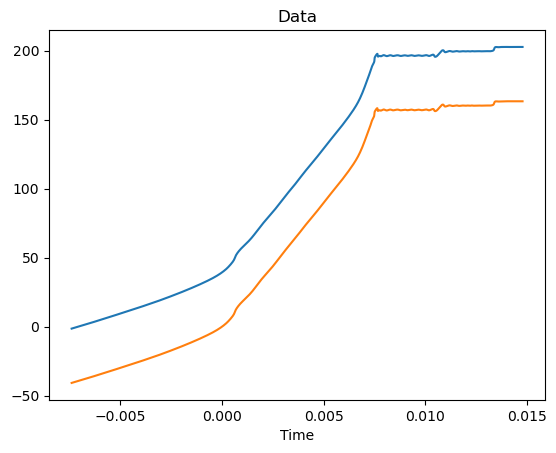

In [13]:
df_Whisky_data = pd.read_csv('Whisky_ALF2_data.csv')
#Plot SXS Data to test
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['Real_h'])
#plt.plot(df_Whisky_data['time_sec'], df_Whisky_data['Amp'])
plt.plot(df_Whisky_data['time_sec'], df_Whisky_data['phase_unwrapped'])
plt.plot(df_Whisky_data['time_sec'], df_Whisky_data['recalc_phase'])
#plt.plot(df_Whisky_data['time_sec'], df_Whisky_data['freq'])
plt.xlabel('Time')
#plt.ylabel('Amplitude')
plt.title('Data')

In [14]:
# Call the function to process the data and save it to 'processed_data.csv'
scale_time = uT
scale_h = 1.0
#Process THC Data to test
process_waveform_m(df_THC, 'THC_BLh_data.csv', scale_h, scale_time)

Processed data saved to THC_BLh_data.csv


Text(0.5, 1.0, 'Data')

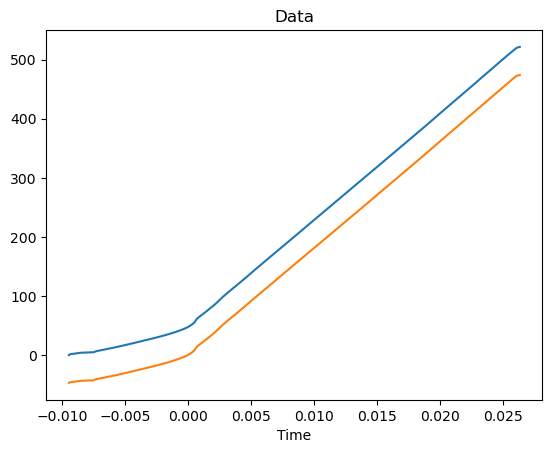

In [15]:
df_THC_data = pd.read_csv('THC_BLh_data.csv')
#Plot SXS Data to test
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['Real_h'])
#plt.plot(df_THC_data['time_sec'], df_THC_data['Amp'])
plt.plot(df_THC_data['time_sec'], df_THC_data['phase_unwrapped'])
plt.plot(df_THC_data['time_sec'], df_THC_data['recalc_phase'])
#plt.plot(df_THC_data['time_sec'], df_THC_data['freq'])
plt.xlabel('Time')
#plt.ylabel('Amplitude')
plt.title('Data')

In [16]:
# Call the function to process the data and save it to 'processed_data.csv'
scale_time = uT
scale_h = 1/MSACRA
#Process SACRA Data to test
process_waveform_m(df_SACRA, 'SACRA_H_data.csv', scale_h, scale_time)

Processed data saved to SACRA_H_data.csv


Text(0, 0.5, 'Data')

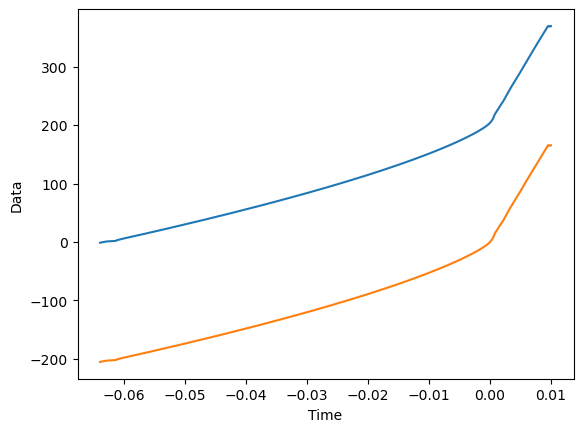

In [18]:
df_SACRA_data = pd.read_csv('SACRA_H_data.csv')
#Plot SXS Data to test
#plt.plot(df_SACRA_data['time_sec'], df_SXS_data['Real_h'])
#plt.plot(df_SACRA_data['time_sec'], df_SACRA_data['Amp'])
plt.plot(df_SACRA_data['time_sec'], df_SACRA_data['phase_unwrapped'])
plt.plot(df_SACRA_data['time_sec'], df_SACRA_data['recalc_phase'])
#plt.plot(df_SACRA_data['time_sec'], df_SACRA_data['freq'])
plt.xlabel('Time')
plt.ylabel('Data')
#plt.title('SACRA Strain')

In [19]:
# Call the function to process the data and save it to 'processed_data.csv'
scale_time = uT
scale_h = 1.0
#Process BAM Data to test
process_waveform_m(df_BAM, 'BAM_MPA1_data.csv', scale_h, scale_time)

Processed data saved to BAM_MPA1_data.csv


Text(0, 0.5, 'Data')

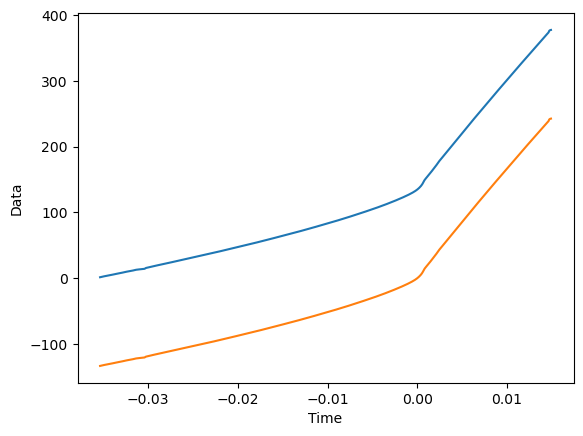

In [20]:
df_BAM_data = pd.read_csv('BAM_MPA1_data.csv')
#Plot SXS Data to test
#plt.plot(df_SXS_data['time_sec'], df_SXS_data['Real_h'])
#plt.plot(df_BAM_data['time_sec'], df_BAM_data['Amp'])
plt.plot(df_BAM_data['time_sec'], df_BAM_data['phase_unwrapped'])
plt.plot(df_BAM_data['time_sec'], df_BAM_data['recalc_phase'])
#plt.plot(df_BAM_data['time_sec'], df_BAM_data['freq'])
plt.xlabel('Time')
plt.ylabel('Data')
#plt.title('BAM Strain')

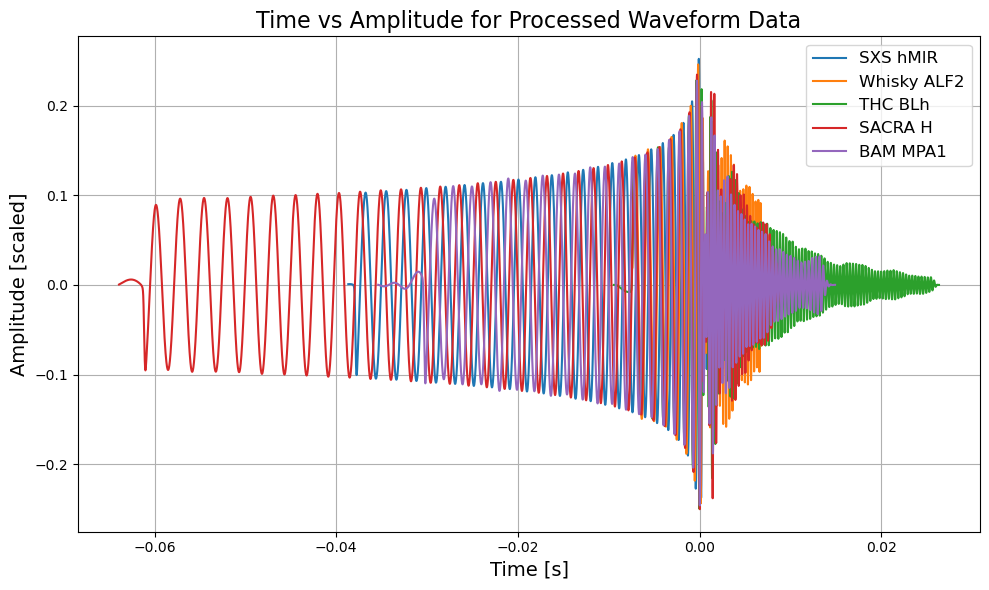

In [21]:
def plot_waveform_data(dfs, labels):
    plt.figure(figsize=(10, 6))  # Set figure size for a clear, publication-ready plot

    # Loop over each DataFrame and plot the corresponding data
    for df, label in zip(dfs, labels):
        plt.plot(df['time_sec'], df['Real_h'], label=label)  # Plot 'time' vs 'Amp'
    
    # Adding labels, title, and legend
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('Amplitude [scaled]', fontsize=14)
    plt.title('Time vs Amplitude for Processed Waveform Data', fontsize=16)
    
    plt.legend(loc='best', fontsize=12)  # Add legend to distinguish datasets
    plt.grid(True)  # Add grid for better readability

    # Improving the appearance for a paper-ready plot
    plt.tight_layout()  # Automatically adjust layout to avoid overlap
    plt.savefig('waveform_plot.png', dpi=300)  # Save plot as high-resolution PNG
    plt.show()  # Show plot in the output

# Plot with loaded DataFrames
dfs = [df_SXS_data, df_Whisky_data, df_THC_data, df_SACRA_data, df_BAM_data]  # List of DataFrames
labels = ['SXS hMlR', 'Whisky ALF2', 'THC BLh', 'SACRA H', 'BAM MPA1']  # Labels for each DataFrame
plot_waveform_data(dfs, labels)

/var/folders/z_/8qxrc1dd5pb7vpgvv8k13j5h0000gn/T/ipykernel_3395/2073745443.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


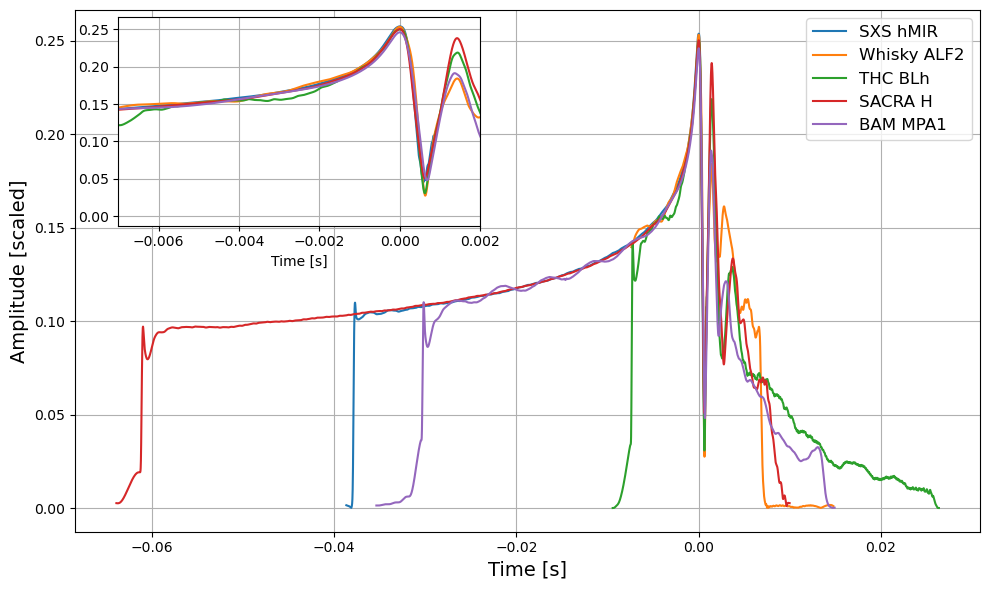

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_waveform_data_with_inset(dfs, labels, zoom_range=(-0.05, 0.05), save_as_pdf=True):
    fig, ax = plt.subplots(figsize=(10, 6))  # Main figure and axis

    # Loop over each DataFrame and plot the corresponding data
    for df, label in zip(dfs, labels):
        ax.plot(df['time_sec'], df['Amp'], label=label)  # Plot 'time' vs 'Amp'

    # Adding labels, title, and legend for the main plot
    ax.set_xlabel('Time [s]', fontsize=14)
    ax.set_ylabel('Amplitude [scaled]', fontsize=14)
   # ax.set_title('Time vs Amplitude for Processed Waveform Data', fontsize=16)
    ax.legend(loc='best', fontsize=12)  # Legend
    ax.grid(True)

    # Create an inset for the zoomed-in region
    ax_inset = inset_axes(ax, width="100%", height="100%", 
                          bbox_to_anchor=(0.04, 0.6, 0.4, 0.4), bbox_transform=ax.transAxes, loc="upper left")  # Inset at upper left

    # Plot the same data in the inset but zoomed in on the specific range
    for df, label in zip(dfs, labels):
        ax_inset.plot(df['time_sec'], df['Amp'], label=label)

    # Set the zoom range for the inset
    ax_inset.set_xlim(zoom_range)
    #ax_inset.set_ylim([min([df['Amp'].min() for df in dfs]), max([df['Amp'].max() for df in dfs])])

    # Add labels to the inset
    ax_inset.set_xlabel('Time [s]', fontsize=10)
    #ax_inset.set_ylabel('Amplitude', fontsize=10)
    ax_inset.grid(True)
    #ax_inset.set_title(f'Zoomed region: {zoom_range[0]}s to {zoom_range[1]}s', fontsize=10)

    # Improving the appearance for a paper-ready plot
    plt.tight_layout()

    # Save the plot as a PDF or PNG
    if save_as_pdf:
        plt.savefig('waveform_plot_with_inset.pdf', dpi=300, format='pdf')  # Save as PDF
    else:
        plt.savefig('waveform_plot_with_inset.png', dpi=300)  # Save as PNG

    plt.show()  # Display the plot

# Example usage with loaded DataFrames and zoom inset
dfs = [df_SXS_data, df_Whisky_data, df_THC_data, df_SACRA_data, df_BAM_data]  # List of DataFrames
labels = ['SXS hMlR', 'Whisky ALF2', 'THC BLh', 'SACRA H', 'BAM MPA1']  # Labels for each DataFrame
plot_waveform_data_with_inset(dfs, labels, zoom_range=(-0.007, 0.002), save_as_pdf=True)